In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from numpy.random import randint, randn
from time import time
from scipy.stats import norm
import tqdm
import seaborn as sns

Runtime: 1.81018 sec
Bootstrap Statistics :
original           bias      std. error
 99.9604  15.2698        99.9586        0.154044


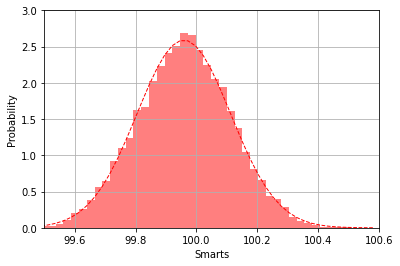

In [18]:
# Returns mean of bootstrap samples                                                                                                                                                
def stat(data):
    return np.mean(data)

# Bootstrap algorithm
def bootstrap(data, statistic, R):
    t = np.zeros(R); n = len(data); inds = np.arange(n); t0 = time()
    # non-parametric bootstrap         
    for i in range(R):
        t[i] = statistic(data[randint(0,n,n)])

    # analysis    
    print("Runtime: %g sec" % (time()-t0)); print("Bootstrap Statistics :")
    print("original           bias      std. error")
    print("%8g %8g %14g %15g" % (statistic(data), np.std(data),np.mean(t),np.std(t)))
    return t


mu, sigma = 100, 15
datapoints = 10000
x = mu + sigma*randn(datapoints)
# bootstrap returns the data sample                                    
t = bootstrap(x, stat, datapoints)
# the histogram of the bootstrapped  data                                                                                                    
n, binsboot, patches = plt.hist(t, 50, density=True, facecolor='red', alpha=0.5)

# add a 'best fit' line  
y = norm.pdf( binsboot, np.mean(t), np.std(t))
lt = plt.plot(binsboot, y, 'r--', linewidth=1)
plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.axis([99.5, 100.6, 0, 3.0])
plt.grid(True)

plt.show()

## The curves indicate that the model with an 8th term has a dramatically smaller test set MSE than the model with only a linear term.
## Cross-validation approach is simple but has 2 potential drawbacks:
1. The validation estimate of the test error rate can be variable, depending on precisely which observations are included in the training set and which are included in the test set. 


2. Only a subset of the observations (those in the training set) are used to fit the model. Since statistical methods tend to perform worse when trained on fewer observations, the validation set error rate may tend to overestimate the test error rate for the model fit on the entire data set.

(400, 1)
(400, 1)


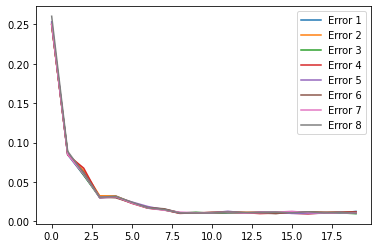

In [23]:
np.random.seed(1907)

n = 400
maxdegree = 20

# Make data set.
# -1 means the remaining dimension becomes whatever shape is needed to make it hold all the original data
x = np.linspace(-3, 3, n).reshape(-1, 1)  
print(x.shape)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)
print(y.shape)
error1 = np.zeros(maxdegree)
error2 = np.zeros(maxdegree)
error3 = np.zeros(maxdegree)
error4 = np.zeros(maxdegree)
error5 = np.zeros(maxdegree)
error6 = np.zeros(maxdegree)
error7 = np.zeros(maxdegree)
error8 = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

n_boostraps = [error1, error2, error3, error4, error5, error6, error7, error8]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

for i in range(len(n_boostraps)):
    for degree in range(maxdegree):
        model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
        y_pred = np.empty((y_test.shape[0], 1))

        x_, y_ = resample(x_train, y_train)
        y_pred[:, 0] = model.fit(x_, y_).predict(x_test).ravel()

        polydegree[degree] = degree
        n_boostraps[i][degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
        bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
        variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    #    print('Polynomial degree:', degree)
    #    print('Error:', error[degree])
    #    print('Bias^2:', bias[degree])
    #    print('Var:', variance[degree])
    #    print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))


    plt.plot(polydegree, n_boostraps[i], label='Error %s' %(i+1))
    # plt.plot(polydegree, bias, label='bias')
    # plt.plot(polydegree, variance, label='Variance')
    plt.legend()

plt.show()

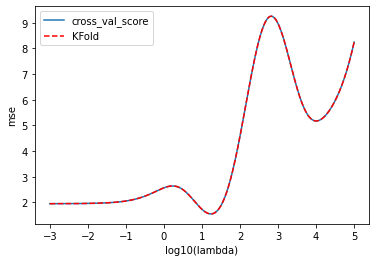

In [2]:
# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(3155)

# Generate the data.
nsamples = 100
x = np.random.randn(nsamples)
y = 3*x**2 + np.random.randn(nsamples)

## Cross-validation on Ridge regression using KFold only

# Decide degree on polynomial to fit
poly = PolynomialFeatures(degree = 6)

# Decide which values of lambda to use
nlambdas = 500
lambdas = np.logspace(-3, 5, nlambdas)

# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k)

# Perform the cross-validation to estimate MSE
scores_KFold = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        xtrain = x[train_inds]
        ytrain = y[train_inds]

        xtest = x[test_inds]
        ytest = y[test_inds]

        Xtrain = poly.fit_transform(xtrain[:, np.newaxis])
        ridge.fit(Xtrain, ytrain[:, np.newaxis])

        Xtest = poly.fit_transform(xtest[:, np.newaxis])
        ypred = ridge.predict(Xtest)

        scores_KFold[i,j] = np.sum((ypred - ytest[:, np.newaxis])**2)/np.size(ypred)

        j += 1
    i += 1


estimated_mse_KFold = np.mean(scores_KFold, axis = 1)

## Cross-validation using cross_val_score from sklearn along with KFold

# kfold is an instance initialized above as:
# kfold = KFold(n_splits = k)

estimated_mse_sklearn = np.zeros(nlambdas)
i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)

    X = poly.fit_transform(x[:, np.newaxis])
    estimated_mse_folds = cross_val_score(ridge, X, y[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)

    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)

    i += 1

## Plot and compare the slightly different ways to perform cross-validation

plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_sklearn, label = 'cross_val_score')
plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('mse')

plt.legend()

plt.show()

In ridge regression we include a regularizer. This involves a new cost function which leads to a new estimate for the weights $\boldsymbol{\beta}$. This results in a penalized regression problem. The cost function is given by 120
The Lasso regression is less straightforward. 

We see that LASSO reaches a good solution for low values of $\lambda$, but will "wither" when we increase $\lambda$ too much. Ridge is more stable over a larger range of values for $\lambda$, but eventually also fades away.

To determine which value of $\lambda$ is best we plot the accuracy of the models when predicting the training and the testing set. We expect the accuracy of the training set to be quite good, but if the accuracy of the testing set is much lower this tells us that we might be subject to an overfit model. The ideal scenario is an accuracy on the testing set that is close to the accuracy of the training set.


/tmp/ipykernel_19524/3870473209.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)


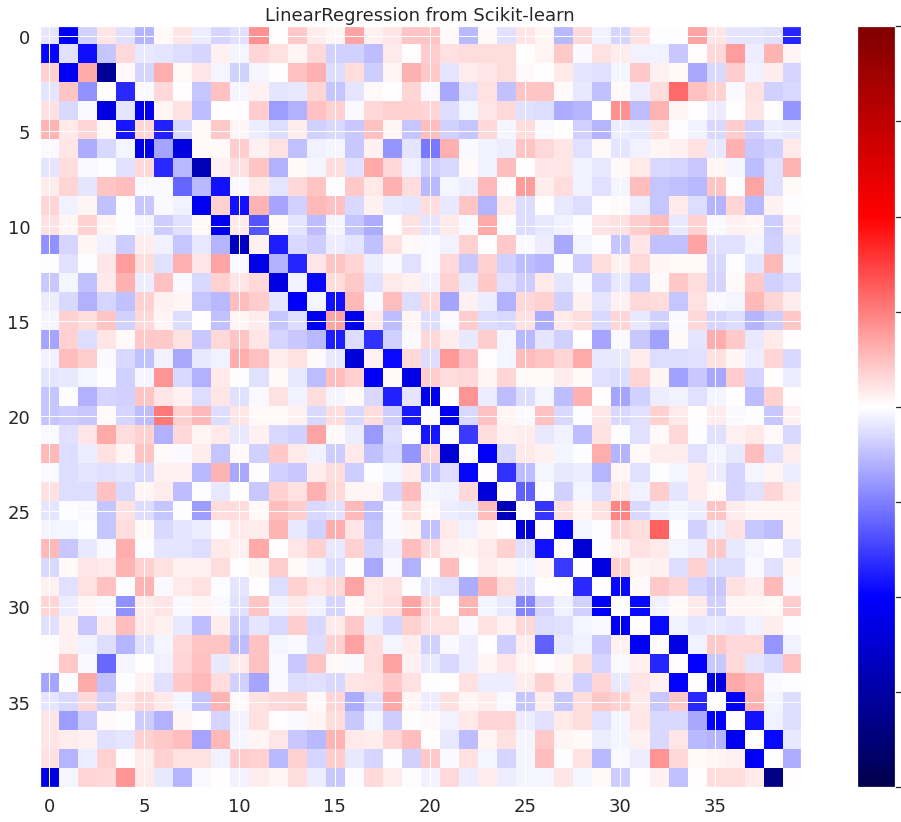

/tmp/ipykernel_19524/3870473209.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)


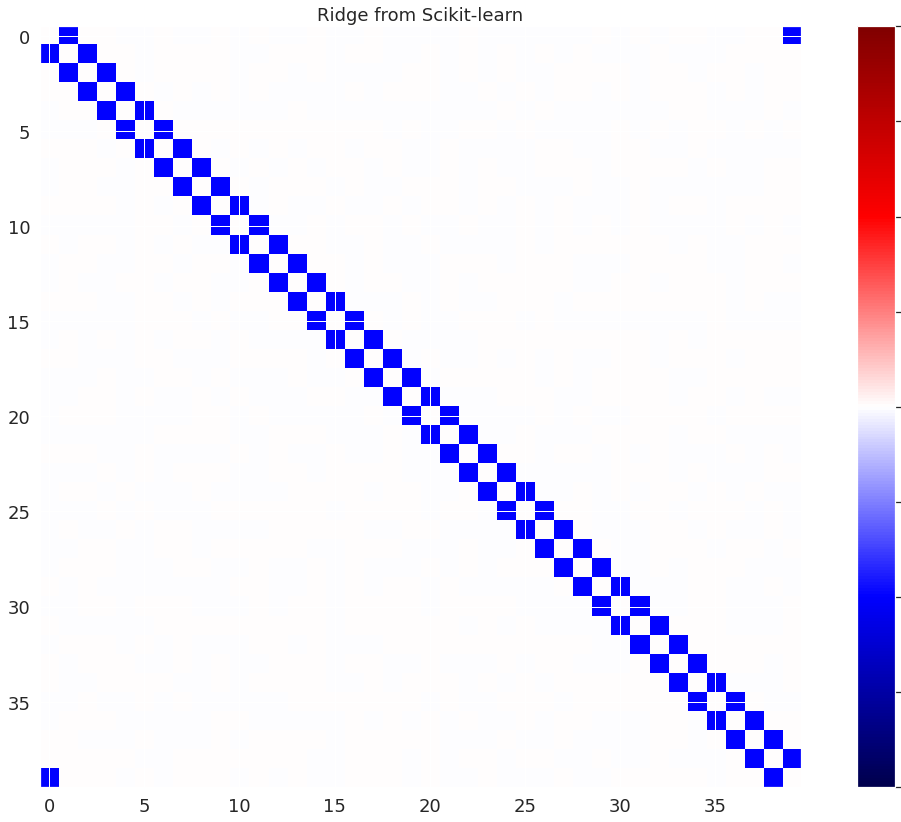

/tmp/ipykernel_19524/3870473209.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)


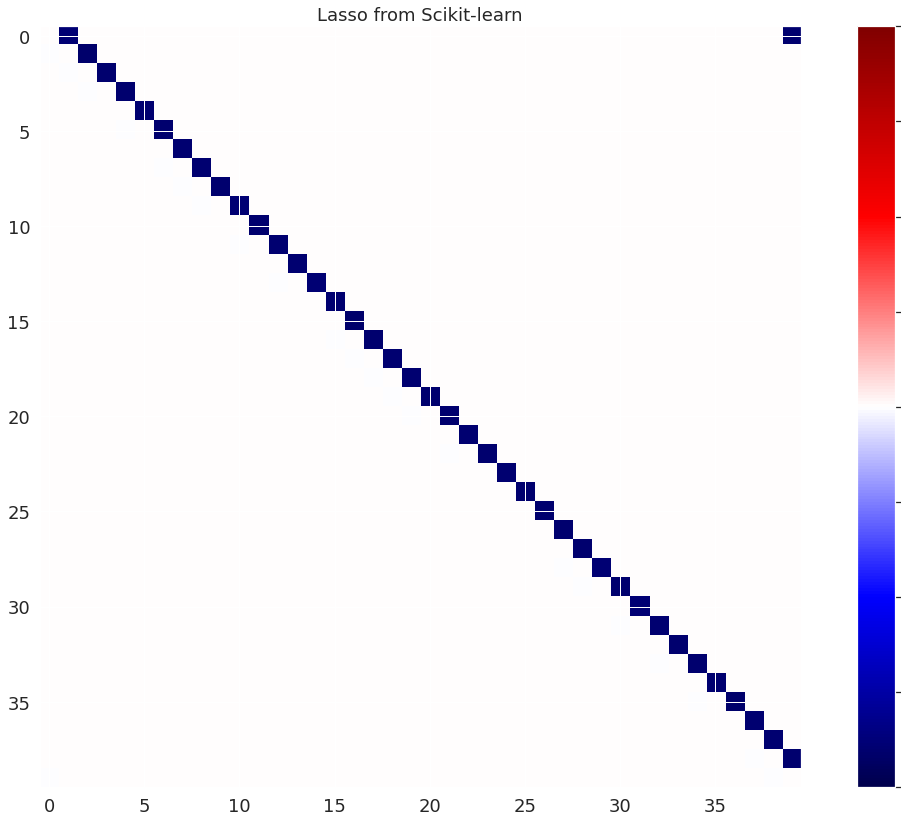

100%|██████████| 10/10 [00:58<00:00,  5.84s/it]


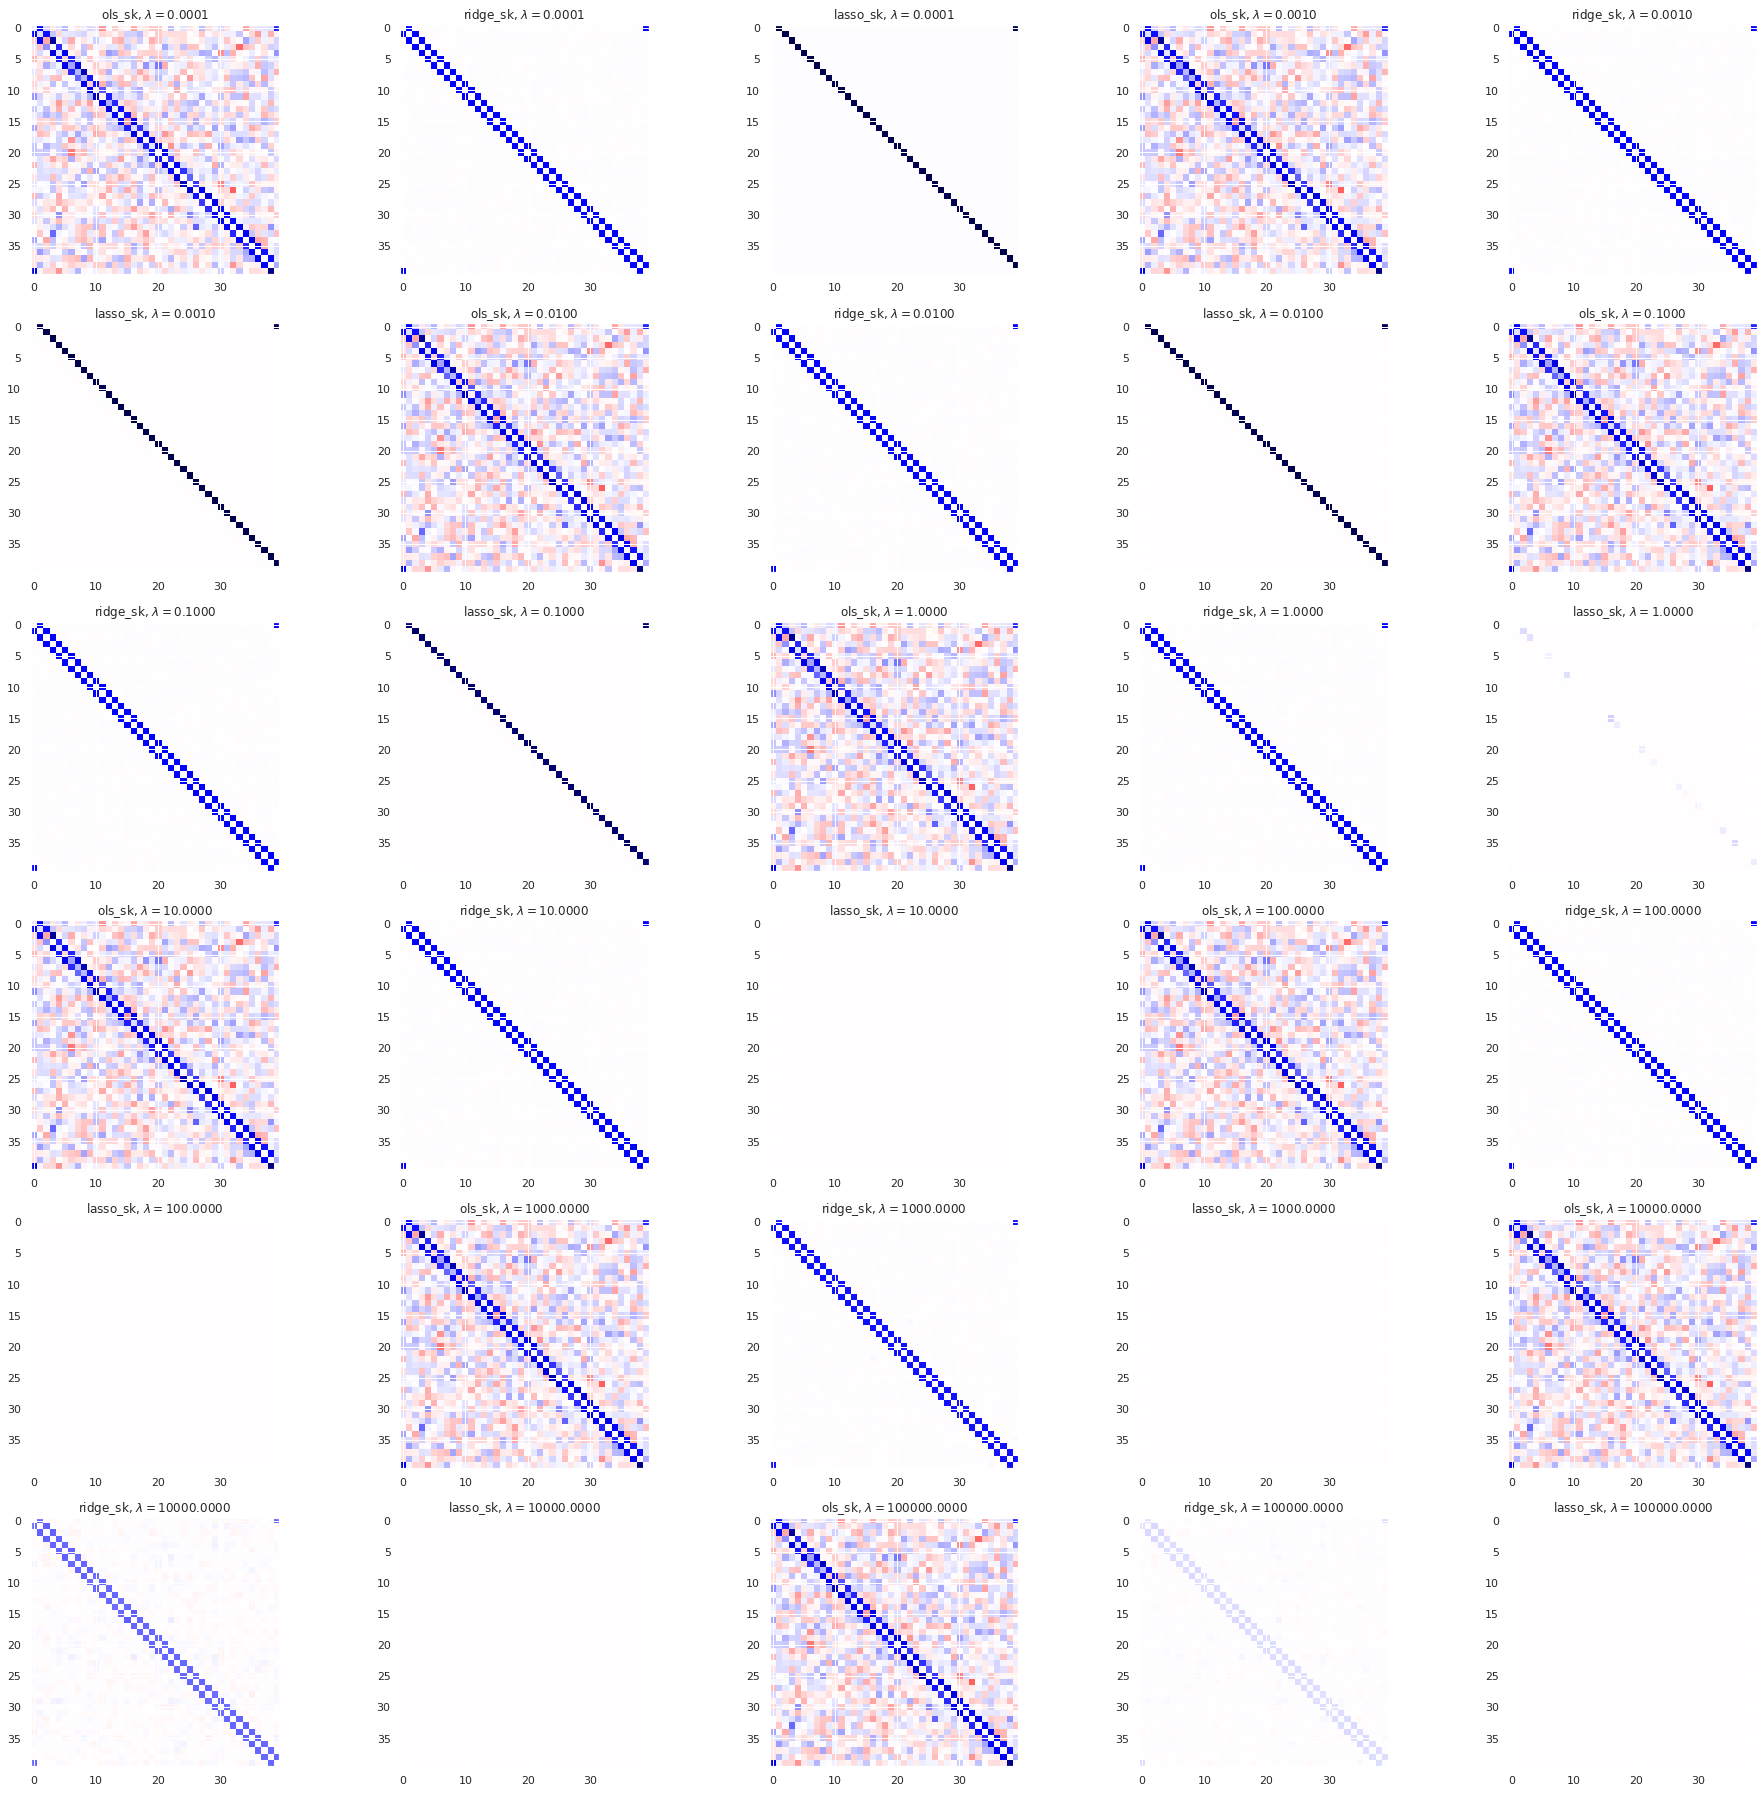

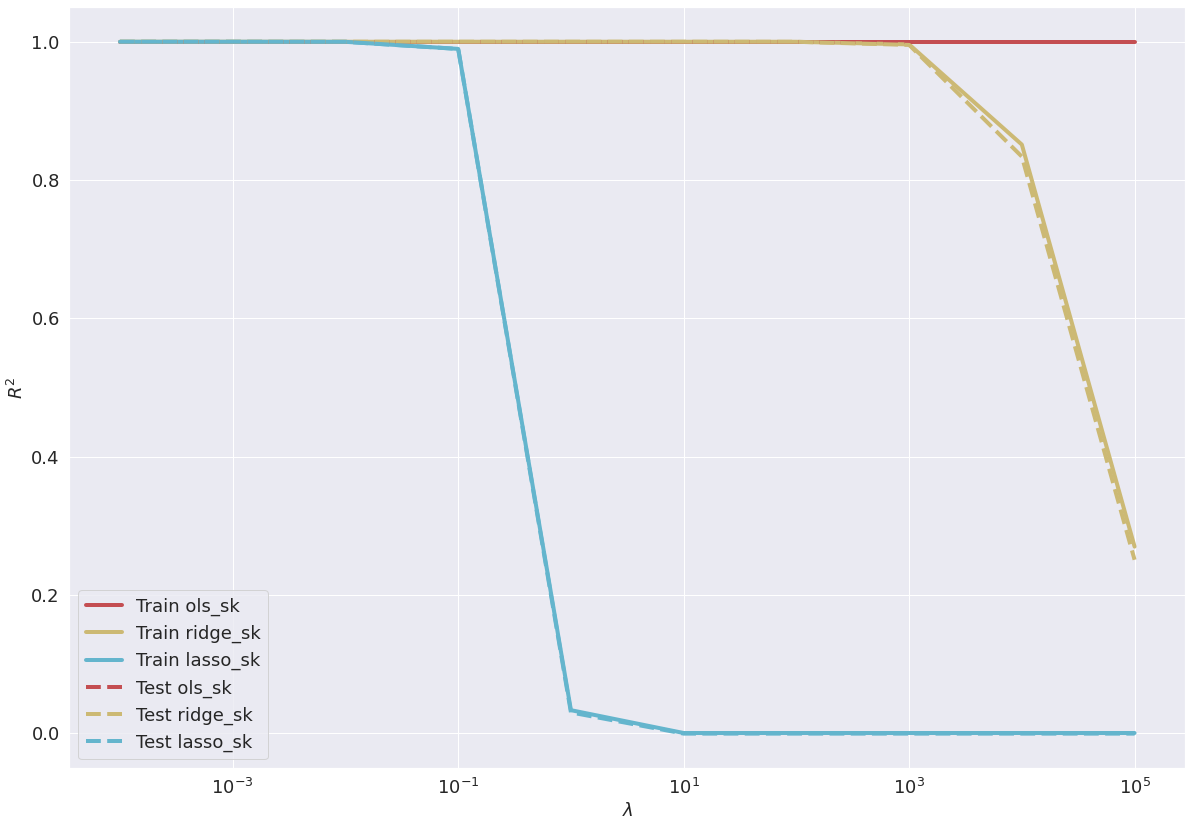

In [34]:
sns.set(color_codes=True)
cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

L = 40
n = int(1e4)

spins = np.random.choice([-1, 1], size=(n, L))
J = 1.0

energies = np.zeros(n)

for i in range(n):
    energies[i] = - J * np.dot(spins[i], np.roll(spins[i], 1))

X = np.zeros((n, L ** 2))
for i in range(n):
    X[i] = np.outer(spins[i], spins[i]).ravel()
y = energies
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)    
X_train_own = np.concatenate(
    (np.ones(len(X_train))[:, np.newaxis], X_train),
    axis=1
)

X_test_own = np.concatenate(
    (np.ones(len(X_test))[:, np.newaxis], X_test),
    axis=1
)

# Linear Regression
clf = LinearRegression().fit(X_train, y_train)
J_sk = clf.coef_.reshape(L, L)
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_sk, **cmap_args)
plt.title("LinearRegression from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)
plt.show()

# Ridge Regression
_lambda = 0.1
clf_ridge = Ridge(alpha=_lambda).fit(X_train, y_train)
J_ridge_sk = clf_ridge.coef_.reshape(L, L)
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_ridge_sk, **cmap_args)
plt.title("Ridge from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)
plt.show()

# Lasso Regression
clf_lasso = Lasso(alpha=_lambda).fit(X_train, y_train)
J_lasso_sk = clf_lasso.coef_.reshape(L, L)
fig = plt.figure(figsize=(20, 14))
im = plt.imshow(J_lasso_sk, **cmap_args)
plt.title("Lasso from Scikit-learn", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=18)
plt.show()

lambdas = np.logspace(-4, 5, 10)
train_errors = {
    "ols_sk": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

test_errors = {
    "ols_sk": np.zeros(lambdas.size),
    "ridge_sk": np.zeros(lambdas.size),
    "lasso_sk": np.zeros(lambdas.size)
}

plot_counter = 1

fig = plt.figure(figsize=(32, 54))

for i, _lambda in enumerate(tqdm.tqdm(lambdas)):
    for key, method in zip(
        ["ols_sk", "ridge_sk", "lasso_sk"],
        [LinearRegression(), Ridge(alpha=_lambda), Lasso(alpha=_lambda)]
    ):
        method = method.fit(X_train, y_train)

        train_errors[key][i] = method.score(X_train, y_train)
        test_errors[key][i] = method.score(X_test, y_test)

        omega = method.coef_.reshape(L, L)

        plt.subplot(10, 5, plot_counter)
        plt.imshow(omega, **cmap_args)
        plt.title(r"%s, $\lambda = %.4f$" % (key, _lambda))
        plot_counter += 1
plt.show()


fig = plt.figure(figsize=(20, 14))

colors = {
    "ols_sk": "r",
    "ridge_sk": "y",
    "lasso_sk": "c"
}

for key in train_errors:
    plt.semilogx(
        lambdas,
        train_errors[key],
        colors[key],
        label="Train {0}".format(key),
        linewidth=4.0
    )

for key in test_errors:
    plt.semilogx(
        lambdas,
        test_errors[key],
        colors[key] + "--",
        label="Test {0}".format(key),
        linewidth=4.0
    )
plt.legend(loc="best", fontsize=18)
plt.xlabel(r"$\lambda$", fontsize=18)
plt.ylabel(r"$R^2$", fontsize=18)
plt.tick_params(labelsize=18)
plt.show()
